In [1]:
from env import RouterEnv
from bandit_algo import BanditAlgorithm
from preference_estimator import (
    EmpiricalEstimator, 
    NeuralEstimator, 
    RecurrentNeuralEstimator,
    RecurrentNeuralEstimatorV0,
    )
from exploration_strategy import (
    PerArmExploration, 
    )
from lightning_lite.utilities.seed import seed_everything
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid")
from matplotlib.pyplot import figure
plt.style.use("fivethirtyeight")
# plt.style.use("ggplot")

/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_tasks = 2
num_cls = 10
reduce_fator = 2
num_candidates = 64
num_slates = num_candidates // reduce_fator
num_samples = 24000
# existing_samples = np.array([[0, 0],
#                             [10, 10]])
# target_samples = np.array([[10, 10],
#                            [10, 10]])
num_data_sent = num_samples // reduce_fator
target_samples = np.ones((num_tasks, num_cls)) * (num_data_sent // num_cls)
existing_samples = np.zeros((num_tasks, num_cls))
existing_samples[1, :] = target_samples[1, :]
print(target_samples)
print(existing_samples)

env = RouterEnv(existing_samples, target_samples,
                cfg={"num_candidates": num_candidates,
                        "num_samples": num_samples,
                        "num_slates": num_slates,
                        "num_tasks": num_tasks,
                        "num_classes": num_cls, })


[[1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]
 [1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]]
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.]]


In [3]:
def main(algo, env):
    seed_everything(0)
    obs = env.reset()
    # print("initial obs:", obs)
    done = False
    step_rewards = []
    pred_losses = []
    while not done:
        action = algo.predict(obs)
        next_obs, reward, done, info = env.step(action)
        # print("obs:", obs, "action", action, "next_obs",
        #       next_obs, "reward", info["rewards"], "done", done)
        algo.update_estimator(obs, action, info["rewards"])
        obs = next_obs
        step_rewards.append(reward)
        pred_loss = (algo.estimator.Q - env.Q) ** 2
        pred_losses.append(pred_loss)

    print("current samples after training:")
    print(env.current_samples)
    routed_data = env.current_samples - existing_samples
    print("routed data:")
    print(routed_data)
    pred_losses = np.array(pred_losses)
    return step_rewards, pred_losses

In [4]:
estimators = [EmpiricalEstimator, NeuralEstimator, RecurrentNeuralEstimatorV0]
estimator_step_rewards, estimator_pred_losses = {}, {}
for estimator_cls in estimators:
    estimator = estimator_cls(num_tasks, num_cls)
    explore = PerArmExploration(num_tasks, num_cls, num_slates)
    algo = BanditAlgorithm(
        estimator,
        explore,
    )
    print("=== Estimator:", estimator_cls.__name__, "===")
    step_rewards, pred_losses = main(algo, env)
    estimator_pred_losses[estimator_cls.__name__] = pred_losses
    estimator_step_rewards[estimator_cls.__name__] = step_rewards

Global seed set to 0


=== Estimator: EmpiricalEstimator ===


Global seed set to 0


current samples after training:
[[1067. 1085. 1148. 1132. 1183. 1169. 1156. 1081. 1088. 1107.]
 [1226. 1227. 1226. 1227. 1225. 1227. 1226. 1225. 1227. 1227.]]
routed data:
[[1067. 1085. 1148. 1132. 1183. 1169. 1156. 1081. 1088. 1107.]
 [  26.   27.   26.   27.   25.   27.   26.   25.   27.   27.]]
Neural Estimator num params:  10657
=== Estimator: NeuralEstimator ===


Global seed set to 0


current samples after training:
[[1014. 1042. 1094. 1102. 1136. 1136. 1122. 1062. 1040. 1073.]
 [1269. 1266. 1273. 1281. 1267. 1269. 1262. 1274. 1258. 1283.]]
routed data:
[[1014. 1042. 1094. 1102. 1136. 1136. 1122. 1062. 1040. 1073.]
 [  69.   66.   73.   81.   67.   69.   62.   74.   58.   83.]]
Recurrent Estimator (one-feed) Num params 29409
=== Estimator: RecurrentNeuralEstimatorV0 ===
current samples after training:
[[1023. 1044. 1109. 1081. 1133. 1127. 1088. 1056. 1040. 1077.]
 [1306. 1275. 1274. 1290. 1279. 1264. 1267. 1278. 1256. 1273.]]
routed data:
[[1023. 1044. 1109. 1081. 1133. 1127. 1088. 1056. 1040. 1077.]
 [ 106.   75.   74.   90.   79.   64.   67.   78.   56.   73.]]


EmpiricalEstimator 15.956702222222223
NeuralEstimator 15.820395555555553
RecurrentNeuralEstimatorV0 15.802166666666666


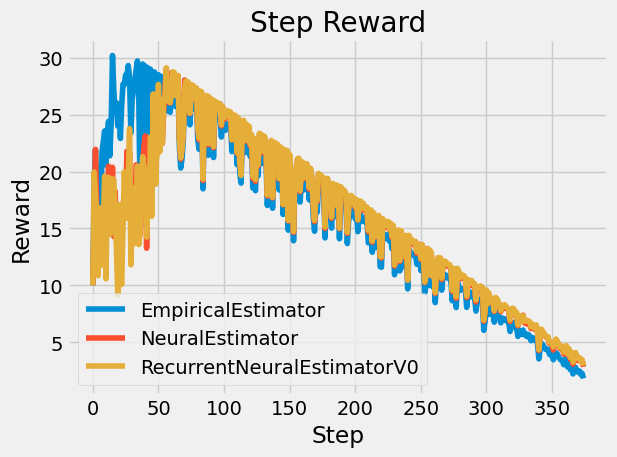

In [15]:
plt.title("Step Reward")
plt.ylabel("Reward")
plt.xlabel("Step")
for estimator_name, step_rewards in estimator_step_rewards.items():
    plt.plot(step_rewards, label=estimator_name)
    print(estimator_name, np.mean(step_rewards))
plt.legend(loc="best");
plt.tight_layout()

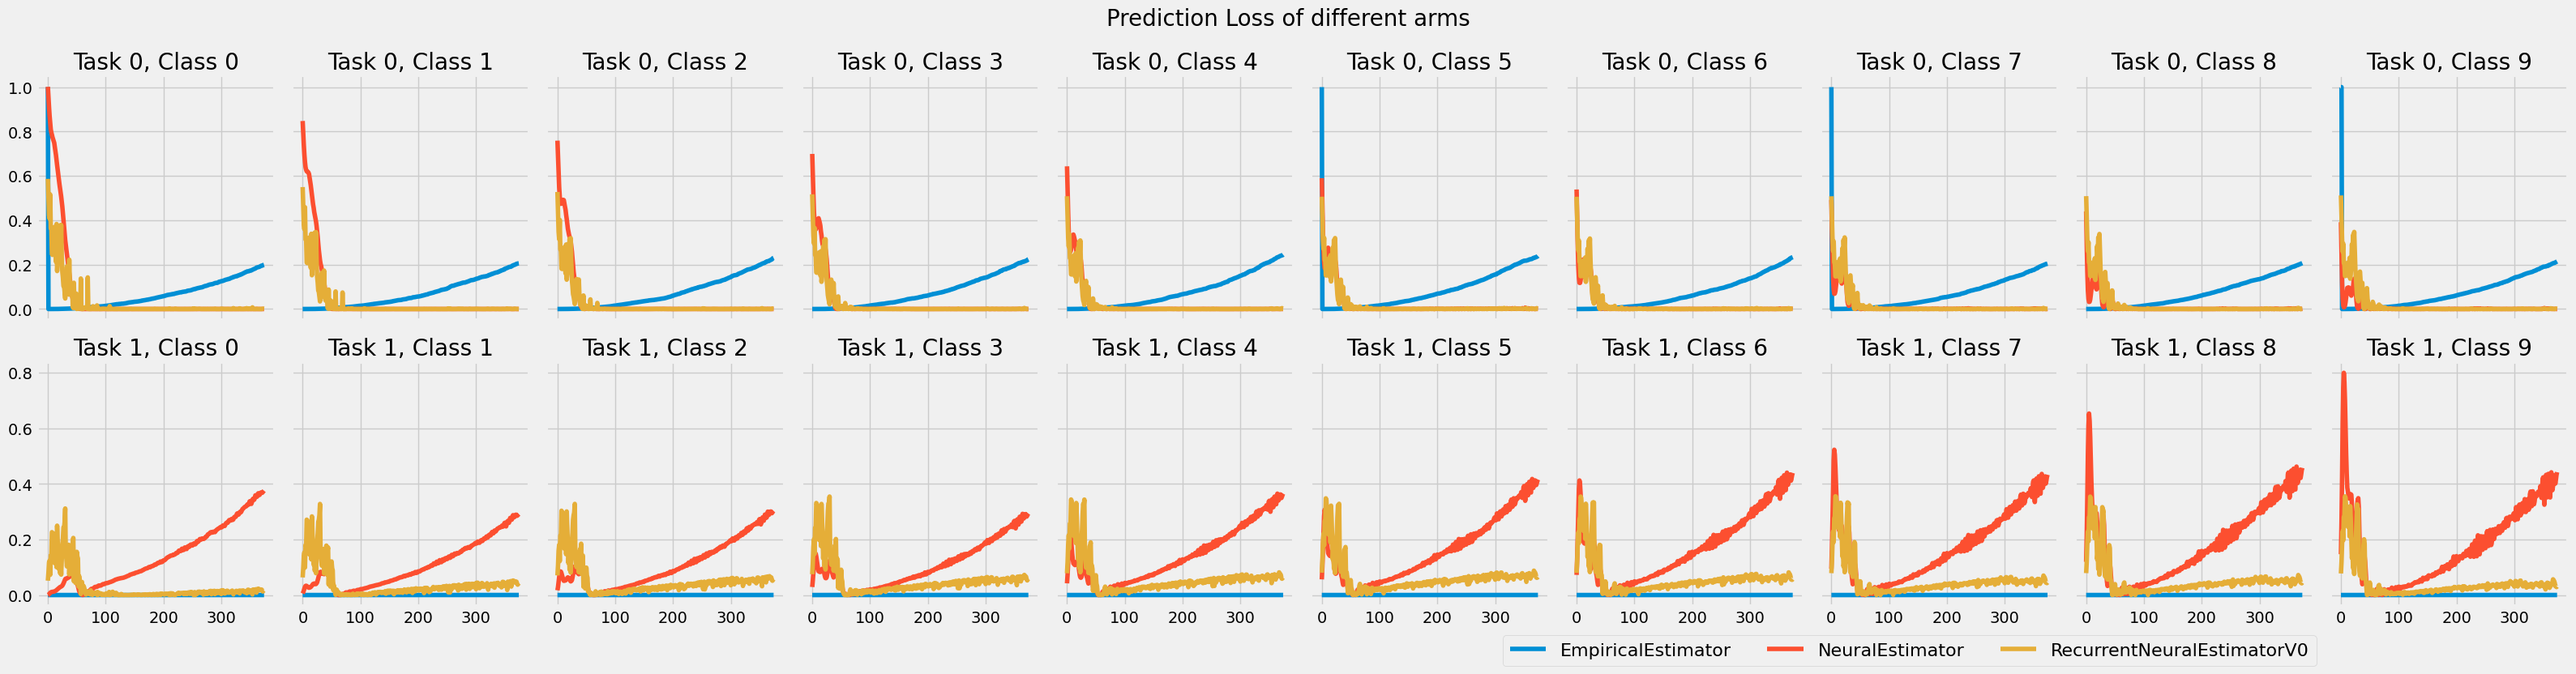

In [18]:
fig, ax = plt.subplots(2, 10, sharex='col', sharey='row', figsize=(32, 8))
# make a single legend for all subplots
for i in range(num_tasks):
    for j in range(num_cls):
        for estimator_name, pred_losses in estimator_pred_losses.items():
            ax[i, j].plot(pred_losses[:, i, j], label=estimator_name)
            ax[i, j].set_title(f"Task {i}, Class {j}")
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, fontsize=16, bbox_to_anchor=(0.9, -0.05));
fig.suptitle("Prediction Loss of different arms", fontsize=20);
plt.tight_layout()

EmpiricalEstimator 0.03677569409233053
NeuralEstimator 0.08744102006371557
RecurrentNeuralEstimatorV0 0.03648721120043003


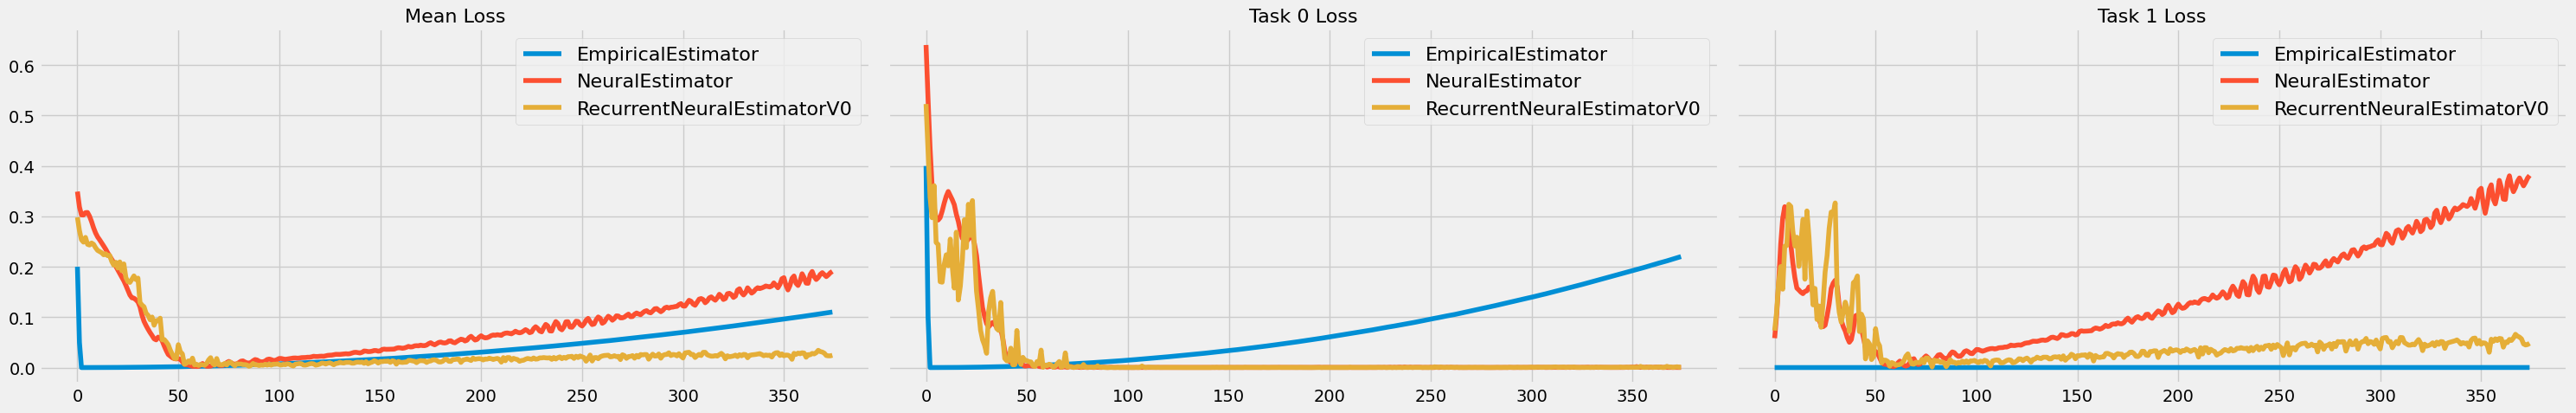

In [17]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(30, 5))
for estimator_name, pred_losses in estimator_pred_losses.items():
    print(estimator_name, np.mean(pred_losses)) 
    mean_loss = np.mean(pred_losses, axis=(1, 2))
    mean_task_0 = np.mean(pred_losses[:, 0, :], axis=1)
    mean_task_1 = np.mean(pred_losses[:, 1, :], axis=1)
    ax[0].plot(mean_loss, label=estimator_name)
    ax[1].plot(mean_task_0, label=estimator_name)
    ax[2].plot(mean_task_1, label=estimator_name)
ax[0].set_title("Mean Loss", fontsize=16)
ax[1].set_title("Task 0 Loss", fontsize=16)
ax[2].set_title("Task 1 Loss", fontsize=16)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[2].legend(fontsize=16);
plt.tight_layout()

In [8]:
for estimator_name in estimator_pred_losses:
    step_rewards = estimator_step_rewards[estimator_name]
    pred_losses = estimator_pred_losses[estimator_name]
    mean_loss = np.mean(pred_losses, axis=(1, 2))
    mean_task_0 = np.mean(pred_losses[:, 0, :], axis=1)
    mean_task_1 = np.mean(pred_losses[:, 1, :], axis=1)
    print("=== Estimator:", estimator_name, "===")
    print("mean_rewards:", np.mean(step_rewards))
    print("mean_loss:", np.mean(mean_loss))
    print("mean_task_0:", np.mean(mean_task_0))
    print("mean_task_1:", np.mean(mean_task_1))
    print()

=== Estimator: EmpiricalEstimator ===
mean_rewards: 15.956702222222223
mean_loss: 0.03677569409233054
mean_task_0: 0.07341963226219289
mean_task_1: 0.00013175592246817766

=== Estimator: NeuralEstimator ===
mean_rewards: 15.820395555555553
mean_loss: 0.08744102006371558
mean_task_0: 0.026480370302534254
mean_task_1: 0.14840166982489691

=== Estimator: RecurrentNeuralEstimatorV0 ===
mean_rewards: 15.802166666666666
mean_loss: 0.03648721120043003
mean_task_0: 0.0222131115119266
mean_task_1: 0.05076131088893347

